In [1]:
from glob import glob
import os

import cv2
import numpy as np
import torch
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from tqdm import tqdm
from scoring import *
from border_and_title import *
from template_extraction import *

# files = [
#     "../data/original/Good/300-014820.pdf",
#     "../data/original/Good/300-014823.pdf",
#     "../data/original/Good/300-014821.pdf",
#     "../data/original/Good/300-014822.pdf"
# ]
# files = [
#     "../data/original/Good/300CRL002.png",
#     "../data/original/Good/300CRL010.png",
# ]
# files = [
#     "../data/original/Ugly/000.000.537.pdf",
#     "../data/original/Ugly/000.001.296.pdf",
#     "../data/original/Ugly/000.001.360.pdf",
#     "../data/original/Ugly/000.001.389.pdf",
#     "../data/original/Ugly/000.895.652.pdf",
#     # "../data/original/Ugly/000.895.659.pdf",
#     # "../data/original/Ugly/000.895.681.pdf",
#     # "../data/original/Ugly/000.895.684.pdf",
#     # "../data/original/Ugly/000.895.701 (1).pdf"
# ]
# files = [
#     "../data/original/Ugly/000.001.024.pdf",
#     "../data/original/Ugly/000.001.303.pdf",
#     "../data/original/Ugly/000.001.373.pdf",
#     "../data/original/Ugly/000.001.423.pdf",
#     "../data/original/Ugly/000.895.692.pdf",
# ]
# files = [
#     "../data/original/Ugly/1.pdf",
#     "../data/original/Ugly/2.pdf",
#     "../data/original/Ugly/3.pdf",
#     "../data/original/Ugly/4.pdf",
#     "../data/original/Ugly/5.pdf",
#     "../data/original/Ugly/6.pdf",
#     "../data/original/Ugly/7.pdf",
#     "../data/original/Ugly/8.pdf",
#     "../data/original/Ugly/9.pdf",
#     "../data/original/Ugly/10.pdf",
#     "../data/original/Ugly/11.pdf"
# ]
# files = [
#     "../data/original/Good/15316-100-D-006_Sheet1.pdf",
#     "../data/original/Good/15316-100-D-020_Sheet2.pdf",
#     "../data/original/Good/15316-100-D-040_Sheet1.pdf",
#     "../data/original/Good/15316-100-D-041_Sheet1.pdf"
# ]

In [2]:
def process(files, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    thickness = 2
    progress = tqdm(total=len(files), desc="Processing Input", leave=True, position=0)
    structures = []
    image_data = []
    for f in files:
        img = read_pdf(f)

        sorted_indices, contours, hierarchy_area = detect_objects(img)
        title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
        ocr_result = data["ocr_result"]
        mask = data["mask"]
        inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
        structures.append(mask)
        image_data.append([f, img, ocr_result, inner_border_lines, title_contours, line_90, sorted_indices, contours, hierarchy_area])
        progress.update()

    borders, template = get_template_borders_from_structures(structures)
    progress = tqdm(total=len(image_data), desc="Processing Output", leave=True, position=0)
    for f, img, ocr_result, inner_border_lines, title_contours, line_90, sorted_indices, contours, hierarchy_area in image_data:
        im_h, im_w, _ = img.shape
        words = process_text(ocr_result, im_h, im_w)

        border_1, border_2 = detect_borders(contours, sorted_indices, words)

        # mask = structures[0]
        # contours = detect_text_tables(img, words, mask)
        # title_contours = title_contours + contours

        boundary = get_boundary(border_1, border_2, inner_border_lines)
        template_lines, intersection_lines, intersection_points = detect_intersection_with_template(img, boundary, borders, tolerance=10)
        img_comp = img.copy()

        for line in template_lines:
            x1, y1, x2, y2 = line
            cv2.line(img_comp, (x1, y1), (x2, y2), (0, 255, 0), 2)

        cv2.rectangle(img_comp, boundary[0], boundary[1], (0, 255, 0), thickness)

        # intersected_extended_lines, boundary_lines, boundary_title_block_lines, intersected_points = detect_intersection_with_borders(img.copy(), boundary, title_boundary, return_states=True)
        # intersected_words = detect_intersected_texts(words, boundary_lines, boundary_title_block_lines)
        # for idx, row in intersected_words.iterrows():
        #     bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
        #     cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (0, 0, 255), 2)

        for point in intersection_points:
            if point is not None:
                x1, y1 = point
                cv2.circle(img_comp, (int(x1), int(y1)), 10, (0, 0, 255), 2)

        cv2.imwrite(f"{output_dir}/{os.path.basename(f)}.jpg", np.hstack((img, img_comp)))
        progress.update(1)

    return template

Processing Input: 100%|██████████| 4/4 [00:04<00:00,  1.27s/it]

Image Similarity: 86.0823%
Image Similarity: 88.7206%
Image Similarity: 85.1641%


Processing Output:  25%|██▌       | 1/4 [00:00<00:01,  1.75it/s]/home/sadid/PycharmProjects/mechanical-drawing-scoring/utils.py:173: RuntimeWarning: overflow encountered in scalar multiply
  x = (b2 * c1 - b1 * c2) / determinant
/home/sadid/PycharmProjects/mechanical-drawing-scoring/utils.py:174: RuntimeWarning: overflow encountered in scalar multiply
  y = (a1 * c2 - a2 * c1) / determinant
Processing Output: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


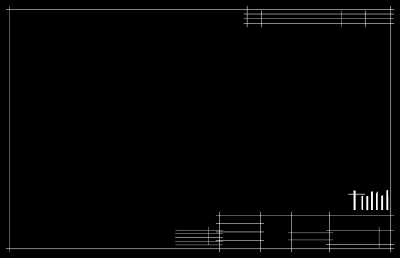

In [3]:
files = [
    "../data/original/Good/300-014820.pdf",
    "../data/original/Good/300-014823.pdf",
    "../data/original/Good/300-014821.pdf",
    "../data/original/Good/300-014822.pdf"
]
t = process(
    files,
    "../data/templates/template_1"
)

Image.fromarray(resize(t, width=400))

Processing Input: 100%|██████████| 5/5 [00:02<00:00,  1.62it/s]

Image Similarity: 94.7579%
Image Similarity: 92.5053%
Image Similarity: 95.3023%
Image Similarity: 93.0575%


Processing Output: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


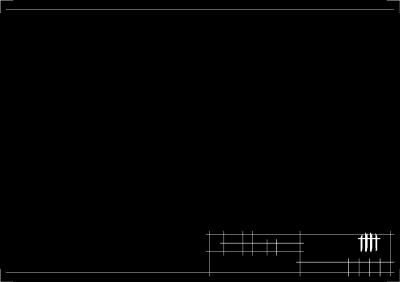

In [4]:
files = [
    "../data/original/Ugly/000.000.537.pdf",
    "../data/original/Ugly/000.001.296.pdf",
    "../data/original/Ugly/000.001.360.pdf",
    "../data/original/Ugly/000.001.389.pdf",
    "../data/original/Ugly/000.895.652.pdf",
    # "../data/original/Ugly/000.895.659.pdf",
    # "../data/original/Ugly/000.895.681.pdf",
    # "../data/original/Ugly/000.895.684.pdf",
    # "../data/original/Ugly/000.895.701 (1).pdf"
]

t = process(
    files,
    "../data/templates/template_2"
)

Image.fromarray(resize(t, width=400))

Processing Input:   0%|          | 0/5 [00:00<?, ?it/s]/home/sadid/anaconda3/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (139513096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing Input:  60%|██████    | 3/5 [00:03<00:02,  1.19s/it]/home/sadid/anaconda3/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (139513096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing Input: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]

Image processing error
(1500, 2123) (1500, 2120)
Image processing error
(1500, 2123) (1500, 2120)
Image Similarity: 97.1406%
Image processing error
(1500, 2121) (1500, 2120)


Processing Output: 100%|██████████| 5/5 [00:00<00:00, 10.29it/s]


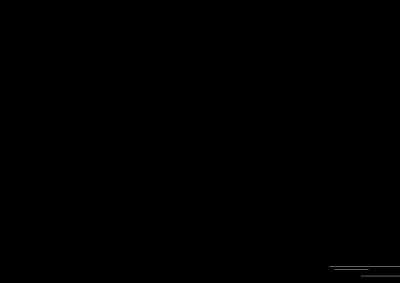

In [5]:
files = [
    "../data/original/Ugly/000.001.024.pdf",
    "../data/original/Ugly/000.001.303.pdf",
    "../data/original/Ugly/000.001.373.pdf",
    "../data/original/Ugly/000.001.423.pdf",
    "../data/original/Ugly/000.895.692.pdf",
]

t = process(
    files,
    "../data/templates/template_3"
)

Image.fromarray(resize(t, width=400))

Processing Input: 100%|██████████| 11/11 [00:09<00:00,  1.09it/s]

Image Similarity: 94.2480%
Image Similarity: 87.2008%
Image Similarity: 89.5824%
Image Similarity: 91.8172%
Image Similarity: 88.8584%
Image Similarity: 92.6012%
Image Similarity: 91.2275%
Image Similarity: 93.6129%
Image processing error
(1500, 2318) (1500, 1941)
Image Similarity: 92.5154%


Processing Output:  82%|████████▏ | 9/11 [00:01<00:00,  5.17it/s]/home/sadid/PycharmProjects/mechanical-drawing-scoring/utils.py:174: RuntimeWarning: overflow encountered in scalar multiply
  y = (a1 * c2 - a2 * c1) / determinant
Processing Output:  91%|█████████ | 10/11 [00:02<00:00,  5.14it/s]/home/sadid/PycharmProjects/mechanical-drawing-scoring/utils.py:174: RuntimeWarning: overflow encountered in scalar multiply
  y = (a1 * c2 - a2 * c1) / determinant
Processing Output: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


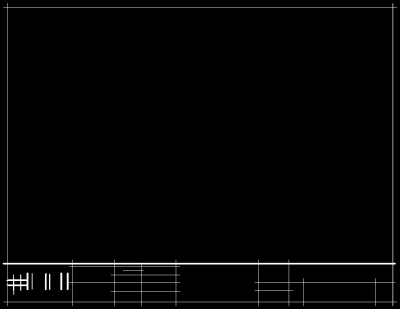

In [6]:
files = [
    "../data/original/Ugly/1.pdf",
    "../data/original/Ugly/2.pdf",
    "../data/original/Ugly/3.pdf",
    "../data/original/Ugly/4.pdf",
    "../data/original/Ugly/5.pdf",
    "../data/original/Ugly/6.pdf",
    "../data/original/Ugly/7.pdf",
    "../data/original/Ugly/8.pdf",
    "../data/original/Ugly/9.pdf",
    "../data/original/Ugly/10.pdf",
    "../data/original/Ugly/11.pdf"
]

t = process(
    files,
    "../data/templates/template_4"
)

Image.fromarray(resize(t, width=400))

Processing Input: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

Image Similarity: 93.8496%
Image Similarity: 93.2276%
Image Similarity: 91.8845%


Processing Output: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


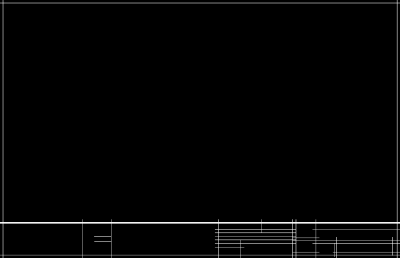

In [7]:
files = [
    "../data/original/Good/15316-100-D-006_Sheet1.pdf",
    "../data/original/Good/15316-100-D-020_Sheet2.pdf",
    "../data/original/Good/15316-100-D-040_Sheet1.pdf",
    "../data/original/Good/15316-100-D-041_Sheet1.pdf"
]

t = process(
    files,
    "../data/templates/template_5"
)

Image.fromarray(resize(t, width=400))